## Quantum PageRank


In [1]:
# Install the relevant packages.
!pip install networkx==3.5

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

### Problem Definition
**PageRank** is an algorithm used to rank nodes—such as web pages or individuals—in directed or undirected graphs based on their relative importance.

Given a graph $G = (V, E)$:  
- $V$ is the set of nodes (e.g., web pages, individuals).  
- $E$ is the set of edges (e.g., hyperlinks/connections between pages/individuals).  

The goal is to assign an importance score to each node based on the number and importance of incoming links.

---

PageRank has broad applications across various fields: ranking web pages in search engines, identifying influential individuals in social networks, recommending products in recommendation systems, and measuring the impact of research papers in scientific citation networks.

Here, we use the Karate Club graph as an example network to rank the importance of each member within the social structure:

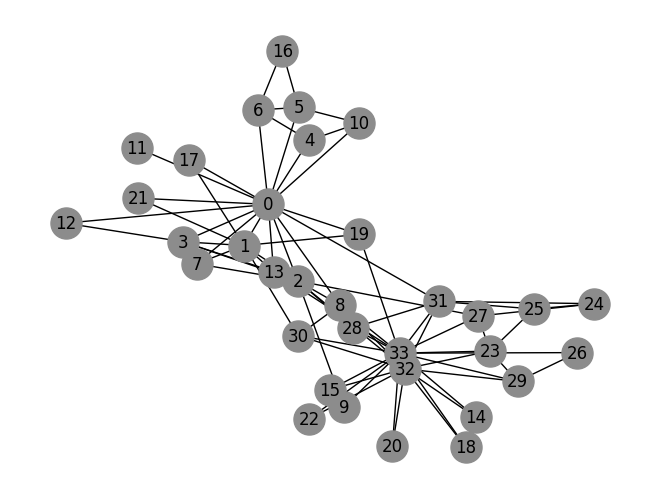

In [3]:
# Load and visualize the Karate Club graph
graph = nx.karate_club_graph()
pos = nx.spring_layout(graph, seed=42)
nx.draw(graph, pos, with_labels=True, node_size=500, node_color='#8C8C8C')

The mathematical foundations of the PageRank algorithm include **Link matrix** $\mathbf{L}$ and **PageRank Matrix** $\mathbf{P}$. Let’s explore their definitions and meanings:
For **Social Network Analysis (SNA)**, the Link matrix $\mathbf{L}$ is used to represent how influence, information, or relationships flow between people (nodes). The entry $L_{ij}$ in row $i$, column $j$ of the matrix shows how much influence person $j$ gives to person $i$ with the following definition:
$$
L_{ij} =
\begin{cases}
\frac{1}{d_j^{\text{out}}} & \text{if there is a link from node } j \text{ to node } i \\
0 & \text{otherwise}
\end{cases}
$$

The Normalization $\frac{1}{d_j^{\text{out}}}$ by the out-degree of node $j$ can be interpreted as the normalized distribution of influence across the network. That is to say,
if person $j$ follows a few people, then their "vote of importance" is evenly split among those $m$ people. So, $L_{ij} = \frac{1}{m}$ for each connection.

In [4]:
# Number of nodes/members
N = len(graph)

# Initialize link matrix L
L = np.zeros((N, N))

# Fill L using out-degree normalization
for j in graph.nodes():  # Column-wise
    neighbors = list(graph.neighbors(j))
    if neighbors:  # Avoid division by zero
        for i in neighbors:
            L[i, j] = 1 / graph.degree[j]  # Normalize by out-degree of node j

To describe the dynamics of a random walker moving through the network, the **PageRank Matrix $\mathbf{P}$** is introduced as below:
$$
\mathbf{P} = \alpha \mathbf{L} + (1 - \alpha) \frac{1}{N} \mathbf{E}
$$
The matrix models the walker's behavior by capturing the probabilities of moving between nodes (with damping factor $\alpha$), considering both the network's link structure (via link matrix $\mathbf{L}$) and the possibility of random jumps through the teleportation matrix $\mathbf{E}$, which ensures unbiased exploration of all nodes with a probability of $1/N$.

In [5]:
# Define parameters
alpha = 0.85  # Damping factor
E = np.ones((N, N)) / N  # Random teleportation matrix

# Build the PageRank Matrix P
P = alpha * L + (1 - alpha) * E

### Simulating Quantum PageRank by CUDA-Q dynamics

Instead of computing PageRank iteratively by [the power method](https://en.wikipedia.org/wiki/PageRank#Power_method), we aim to introduce a [quantum version of PageRank](https://www.nature.com/articles/srep00605) that solves the ranking problem by leveraging the principles of quantum mechanics, specifically [**Quantum Stochastic Walk (QSW)**](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.81.022323), which generalizes classical random walks by incorporating both **coherent quantum evolution** and **incoherent stochastic dynamics**, described by the **Lindblad master equation**:  

$$
\frac{d\rho}{dt} = -i(1-\omega)[H, \rho] + \omega \sum_{k>0} \gamma_k \left( L_k \rho L_k^\dagger - \frac{1}{2} \{L_k^\dagger L_k, \rho\} \right)
$$

### Breakdown of Terms

**Hamiltonian Evolution (coherent):**

$$
-i(1-\omega)[H, \rho]
$$

- $H$ is the Hamiltonian, governing coherent unitary evolution.
- The factor $1 - \omega$ determines the extent of quantum behavior in the system.

**Dissipative Evolution (incoherent):**

$$
\omega \sum_{k > 0} \gamma_k \left( L_k \rho L_k^{\dagger} - \frac{1}{2} \{ L_k^{\dagger} L_k, \rho\} \right)
$$

- $\gamma_k$ are rates associated with each dissipative process.
- $L_k$ are Lindblad operators modeling incoherent jumps between states.

**Parameter $\omega$ controls the interpolation:**

- $\omega = 0$ → Pure Quantum Walk (QW), where only unitary evolution occurs.
- $\omega = 1$ → Pure Classical Random Walk (CRW), where only stochastic transitions occur.
- $0 < \omega < 1$ → Quantum Stochastic Walk (QSW), a hybrid of both.

In brief, this framework naturally extends PageRank, where the dissipators $L_k$ encode stochastic teleportation, similar to the random jumps in classical PageRank. The **Quantum PageRank (QPR)** model based on quantum spatial walks can reveal hidden structures for some networks, enhance ranking sensitivity, and achieve comparable or faster convergence compared to its classical counterpart.

Given the time-dependent nature of quantum stochastic walks, CUDA-Q Dynamic leverages GPU acceleration and provides a suite of APIs for efficiently solving time-evolved states. Let's get started:

In [6]:
import cudaq
from cudaq import operators, Schedule

# Construct the Hamiltonian based on the adjacency matrix of the social network
H = np.array(nx.to_numpy_array(graph), dtype=np.complex128)

# Defines an elementary operator named "hamiltonian", allowing creation with the name and its degrees of freedom.
operators.define("hamiltonian", expected_dimensions=[N], create=lambda: H)

The **Lindblad operators** can be defined for a quantum system represented by a density matrix $\rho$. They facilitate the incorporation of both quantum coherence and incoherent processes into the dynamics.

For Quantum PageRank, the Lindblad operators shown below have been demonstrated to converge to a stationary solution:

$$
L(i,j) = |i\rangle \langle j| \quad
$$

where the indices $i$ and $j$ label the nodes in the network as well as the Lindblad operators. This notation indicates that the operator $L(i,j)$ describes a **transition** from state $|j\rangle$ to state $|i\rangle$.


In [7]:
def lindblad_op(i, j):
    L = np.zeros_like(P, dtype=np.complex128)
    L[i, j] = 1
    return L


# exec hack for https://github.com/NVIDIA/cuda-quantum/issues/2426.
for i in range(N):
    for j in range(N):
        exec(f"""
operators.define(
    f"lindblad_{i,j}",
    expected_dimensions=[N],
    create=lambda: lindblad_op({i}, {j}),
)
        """)

lindblad_ops = [
    np.sqrt(P[i, j]) * operators.instantiate(f"lindblad_{i,j}", [0])
    for i in range(N)
    for j in range(N)
]

Simply simulate the dynamic system via the `evolve` API with `"dynamics"` backend of CUDA-Q:

In [8]:
cudaq.set_target("dynamics")

start = 0
stop = 1


def quantum_pagerank(N, start, stop, lindblad_ops, omega):

    # Define the page labels
    page_labels = list(range(N))

    # Initialize the state
    rho = np.identity(N, dtype=np.complex128) / N

    # Define the Hamiltonian and collapse operators based on the value of omega
    hamiltonian = (1 - omega) * operators.instantiate("hamiltonian", [0])
    collapse_operators = [np.sqrt(omega) * op for op in lindblad_ops]

    result = cudaq.evolve(
        hamiltonian=hamiltonian,
        dimensions={0: N},
        schedule=Schedule(np.linspace(start, stop, 2), ["time"]),
        initial_state=cudaq.State.from_data(rho),
        collapse_operators=lindblad_ops,
    )

    final_state = np.array(result.final_state())

    return dict(zip(page_labels, np.real(np.diag(final_state))))

In [9]:
# For cases where 0 < ω < 1 (e.g., ω = 0.6), the dynamics follow a quantum Stochastic Walk with both coherent and incoherent (dissipative) evolution
pagerank_qsw = quantum_pagerank(N, start, stop, lindblad_ops, omega=0.6)

# For the extreme case ω = 0 reduces the Quantum Stochastic Walk to a purely classical random walk
pagerank_cw = quantum_pagerank(N, start, stop, lindblad_ops, omega=1.0)

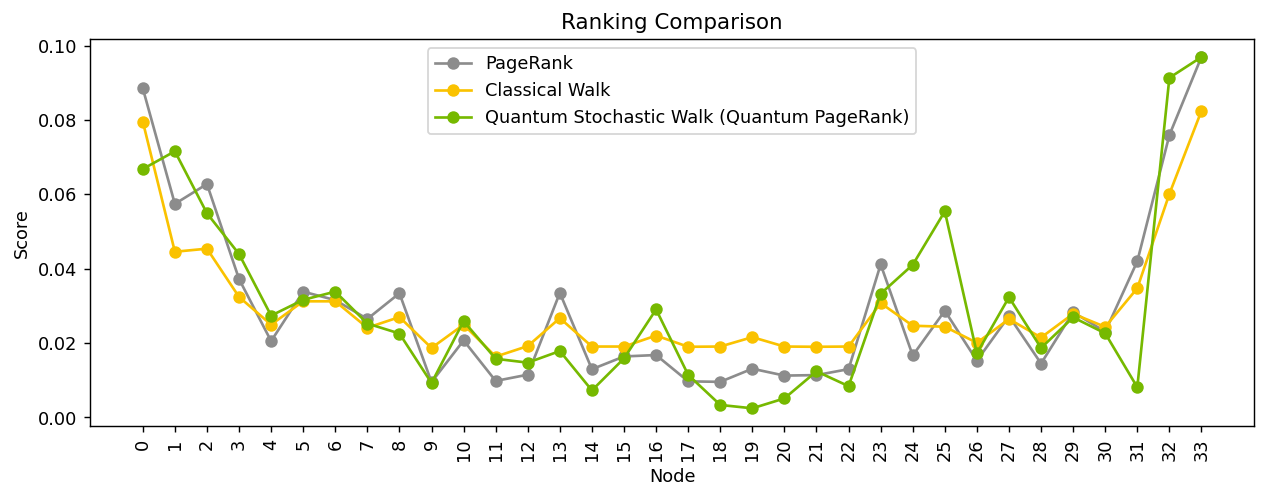

In [10]:
# Compare the results with NetworkX's built-in PageRank algorithm
pagerank = nx.pagerank(graph)

# Plot the results
plt.figure(figsize=(10, 4), dpi=128)

labels = list(pagerank.keys())
plt.plot(labels, [pagerank[n] for n in labels],
         '-o',
         color='#8C8C8C',
         label='PageRank')
plt.plot(labels, [pagerank_cw[n] for n in labels],
         '-o',
         color='#FAC200',
         label='Classical Walk')
plt.plot(labels, [pagerank_qsw[n] for n in labels],
         '-o',
         color='#76B900',
         label='Quantum Stochastic Walk (Quantum PageRank)')

plt.xlabel('Node')
plt.ylabel('Score')
plt.title('Ranking Comparison')
plt.legend()
plt.xticks(labels, rotation=90)
plt.tight_layout()
plt.show()

Note that the ranking results obtained by the Quantum PageRank algorithm show smoother ranking distribution, which reduces the dominance of major hubs, allowing less connected nodes to be fairly recognized. This facilitates the identification of secondary hubs and reveals finer structural details within the network, offering a more nuanced and continuous scale of node importance for complex networks.

---

Finally, let's visualize the ranking results, representing the influence of each node, from the Quantum PageRank using the `CUDA-Q Dynamic` simulation:

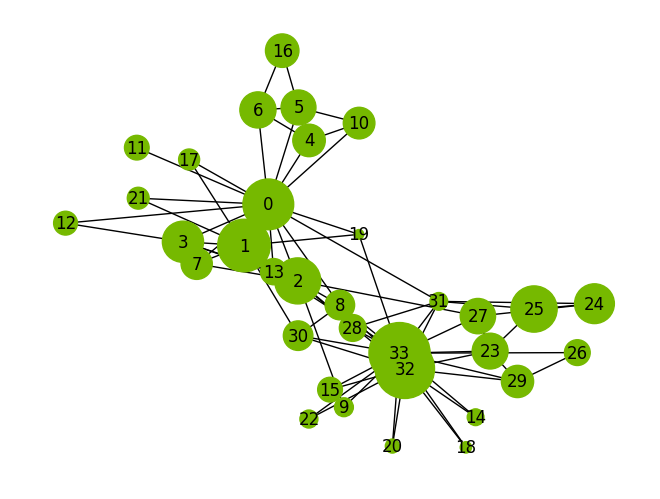

In [11]:
# Scale the node sizes
node_weights = np.array(list(pagerank_qsw.values()))
node_sizes = node_weights * 20000  # Scale factor for visualization

# Draw the graph with node sizes corresponding to the importance of the nodes
pos = nx.spring_layout(graph, seed=42)
nx.draw(graph,
        pos,
        node_size=node_sizes,
        with_labels=True,
        node_color='#76B900')

In [12]:
print(cudaq.__version__)

CUDA-Q Version proto-0.8.0 (https://github.com/NVIDIA/cuda-quantum f8c9c1507fd2741c0af980b9b7028729b1ecc58d)
